<h2 style='color:blue'> Project Dataset </span>

### 1. Telkom University Dataset
- **Link**: [Telkom University Dataset](https://dataverse.telkomuniversity.ac.id/dataset.xhtml?persistentId=doi:10.34820/FK2/QVCP6V)  
- **Source**: Telkom University Dataverse  
- **Number of Images**: Approximately 54 labeled ovarian ultrasound images  
- **Dimension of Images**: Standardized to 300x200 pixels  
- **Size of Dataset**: 1,598 KB (zipped)  

---

### 2. Kaggle Dataset
- **Link**: [Kaggle Dataset](https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images)  
- **Source**: Kaggle platform by user Anagha Choudhari  
- **Number of Images**: 
  - 1,924 training images  
  - 1,932 testing images  
- **Dimension of Images**: Variable (preprocessing required for standardization)  
- **Size of Dataset**: 128,746 KB (zipped)  

---

### 3. Figshare PCOS Dataset
- **Link**: [Figshare PCOS Dataset](https://figshare.com/articles/dataset/PCOS_Dataset/27682557?file=50407062)  
- **Source**: Figshare repository  
- **Number of Images**: 11,748 labeled images  
  - 5,000 healthy cases  
  - 6,748 affected cases  
- **Dimension of Images**: Variable (preprocessing required for standardization)  
- **Size of Dataset**: 381,651 KB (zipped)  

---

### 4. Roboflow PCOS Dataset
- **Link**: [Roboflow PCOS Dataset](https://universe.roboflow.com/pcos-dataset/pcos-detection)  
- **Source**: Roboflow Universe  
- **Number of Images**: 97 standardized images annotated in COCO format  
- **Dimension of Images**: Preprocessed to 416x416 pixels  
- **Size of Dataset**: 2,377 KB (zipped)  

---

### Root Folder Path:
<h4 style ='color:brown;'> `D:\USD Univ. San Diego MS AI\AAI-521\Project Data`


<h2 style='color:blue'>	Data Preprocessing


### Key Steps in the Code:
1. **Setup**: The root folder path and zip files are identified. The `'Standardized images'` folder is created for storing results.
2. **Extract and Process**:
   - Each zip file is extracted.
   - Subfolders and image files are identified.
3. **Image Processing**:
   - Detect and remove uniform intensity padding (if any).
   - Resize the image to 224x224 using `ImageOps.fit` to preserve the aspect ratio with minimal distortion.
4. **Save Processed Images**:
   - Maintain the folder hierarchy inside the `'Standardized images'` directory for easy reference.



<h3 style='color:darkgreen'> Install 'anytree' library

In [10]:
pip install anytree



   ---------------------------------------- 0.0/44.9 kB ? eta -:--:--
   ---------------------------------------- 44.9/44.9 kB 2.3 MB/s eta 0:00:00


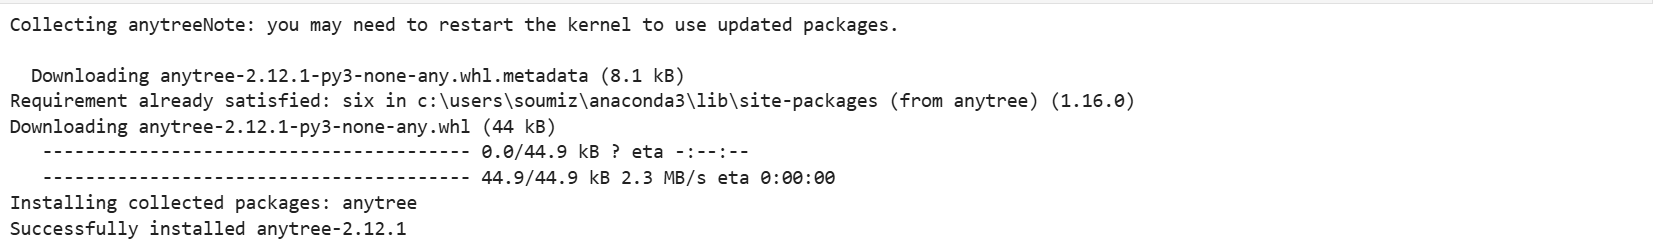e-2.12.1

### 1. Unzipping 

In [3]:
import os
import zipfile
from PIL import Image, ImageOps
import numpy as np
from anytree import Node, RenderTree


def process_images(root_path):
    # Define root folder and output folder
    standardized_images_folder = os.path.join(root_path, "Standardized images")
    os.makedirs(standardized_images_folder, exist_ok=True)

    # Initialize the folder structure dictionary with root folder
    global folder_structure
    folder_structure = {}

    # List all zip files in the root folder
    zip_files = [f for f in os.listdir(root_path) if f.endswith(".zip")]

    for zip_file in zip_files:
        zip_path = os.path.join(root_path, zip_file)
        extracted_folder = os.path.join(standardized_images_folder, os.path.splitext(zip_file)[0])

        # Extract the zip file to the new folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)

        # Build folder structure recursively
        subfolder_structure = {}
        for subdir, _, files in os.walk(extracted_folder):
            relative_path = os.path.relpath(subdir, start=extracted_folder)
            
            # Skip the current directory (".") path
            if relative_path == ".":
                continue

            # Traverse the path to build nested dictionaries
            parts = relative_path.split(os.sep)
            parent_structure = subfolder_structure
            for part in parts:
                if part not in parent_structure:
                    parent_structure[part] = {}
                parent_structure = parent_structure[part]

            # Add files to the "files" key in the current folder
            parent_structure["files"] = files

        folder_structure[os.path.splitext(zip_file)[0]] = subfolder_structure

    # Visualize the folder structure as a tree
    plot_folder_tree(folder_structure)


def plot_folder_tree(folder_structure):
    def add_nodes(parent, structure):
        for key, value in structure.items():
            if key == "files":  # Skip the "files" key
                continue
            # Add child nodes
            child = Node(key, parent=parent)
            if isinstance(value, dict):  # If it's a nested folder, recurse
                add_nodes(child, value)
            elif isinstance(value, list):  # If it's a list of files, add them
                for file in value:
                    Node(file, parent=child)

    # Initialize the root node
    root = Node("PCOS test folder AAI521 [Root]")
    add_nodes(root, folder_structure)

    # Render the tree
    for pre, fill, node in RenderTree(root):
        print(f"{pre}{node.name}")


# Main script
if __name__ == "__main__":
    root_path =  r"D:\USD Univ. San Diego MS AI\AAI-521\Project Data"
    process_images(root_path)


PCOS test folder AAI521 [Root]
├── dataverse_files_54 files
│   ├── testing
│   │   ├── normal
│   │   └── pco
│   ├── train copy
│   │   ├── normal
│   │   └── pco
│   └── validation
│       ├── normal
│       └── pco
├── PCOS detection Kaggle_3854 files
│   └── data
│       ├── test
│       │   ├── infected
│       │   └── notinfected
│       └── train
│           ├── infected
│           └── notinfected
├── PCOS Detection_97 files.v1i.coco
│   ├── test
│   └── train
└── PCOS
    └── PCOS
        ├── infected
        └── noninfected


### 2. Image Standardisation

In [4]:
import os
from PIL import Image, ImageOps
import numpy as np

def process_and_save_image(image_path):
    """
    Process and save an image:
    - Convert to grayscale
    - Remove uniform padding
    - Resize to 224x224
    - Save in the same location
    """
    try:
        # Open the image
        with Image.open(image_path) as img:
            img = img.convert("L")  # Convert to grayscale if not already

            # Remove uniform intensity padding
            img_np = np.array(img)
            mask = img_np != img_np[0, 0]  # Detect uniform intensity areas
            if mask.any():
                coords = np.array(np.nonzero(mask))
                x_min, y_min = coords.min(axis=1)
                x_max, y_max = coords.max(axis=1) + 1  # Include last coordinate
                img_cropped = img.crop((y_min, x_min, y_max, x_max))
            else:
                img_cropped = img  # No padding detected

            # Resize image to 224x224 while preserving aspect ratio
            img_resized = ImageOps.fit(img_cropped, (224, 224), Image.Resampling.LANCZOS)

            # Save the processed image in the same location
            img_resized.save(image_path)

    except Exception as e:
        print(f"\n-------- Ignored processing {image_path}: {e}\n")


def standardize_images(root_folder):
    """
    Traverse all subfolders in the given root folder and standardize images.
    """
    for subdir, _, files in os.walk(root_folder):
        print(f'$ Workking on {root_folder} --> {subdir}') 
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                file_path = os.path.join(subdir, file)
                process_and_save_image(file_path)


# Main script

# Define the folder containing the extracted and organized images
standardized_images_folder = r"D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images"

# Call the function to standardize all images
standardize_images(standardized_images_folder)

# Process Completed
print("\n            Images are standarised\n")

Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images --> D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images
Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images --> D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images\dataverse_files_54 files
Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images --> D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images\dataverse_files_54 files\testing
Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images --> D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images\dataverse_files_54 files\testing\normal
Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images --> D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images\dataverse_files_54 files\testing\pco
Workking on D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images -->